# ***ConsensusClustering*** *R* Package Tutorial

ConsensusClustering **Version 1.4.0**

In this notebook, we provide a comprehensive tutorial of the *ConsensusClustering* pachage. We provide examples for different generation mechanisms:

1. Data perturbation consensus clustering (DPCC);
2. Method perturbation consensus clustering (MPCC);
3. Multi-Data consensus clustering (MDCC).

## 1. Installation

In [1]:
if(!requireNamespace("ConsensusClustering", quietly = TRUE)){

    # Install from CRAN
    # install.packages("ConsensusClustering")

    # Install from GitHub
    devtools::install_git("https://github.com/behnam-yousefi/ConsensusClustering", subdir="package/ConsensusClustering")
}

In [2]:
# Load the library
library(ConsensusClustering)

## 2. Generate simulated data
First, we use functions implemented in the ConsensusClustering package to generate simulated data.
We consider two senarios:

1. Generate three Gaussian clusters (for DPCC and MPCC)
2. Generate multi-view clusters (for MDCC)

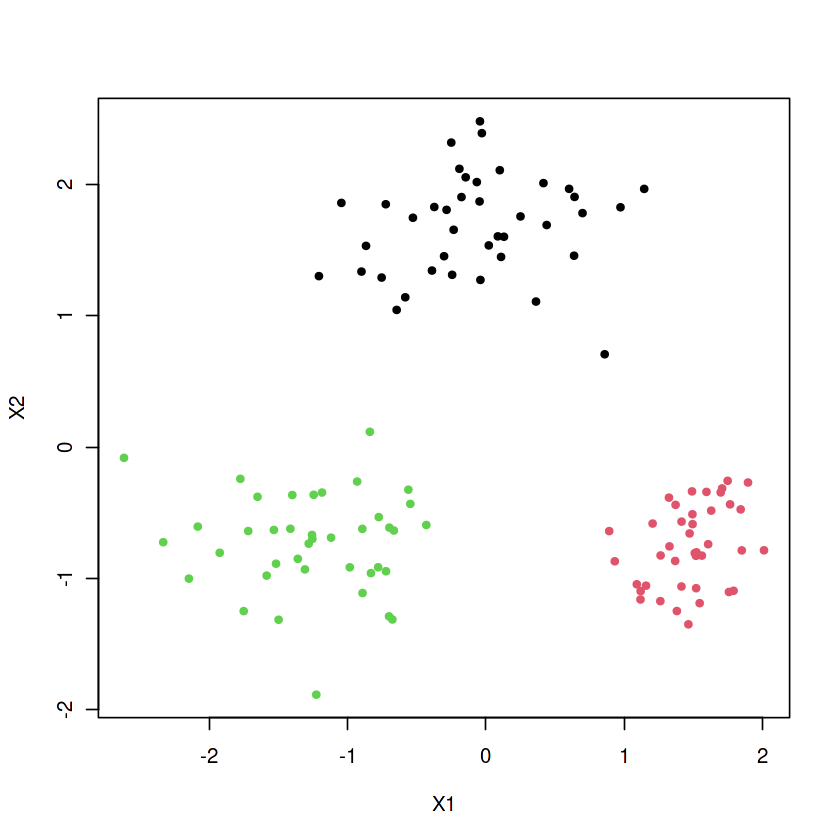

In [3]:
# 1. Generate three Gaussian clusters
set.seed(111)
dim  = 2
data = gaussian_clusters(n = c(40,40,40), dim = dim, sd.max = .5, sd.noise = 0, r.range = c(1,2))
X = data$X
class = data$class
plot(X, pch = 20, col = class, cex = 1)

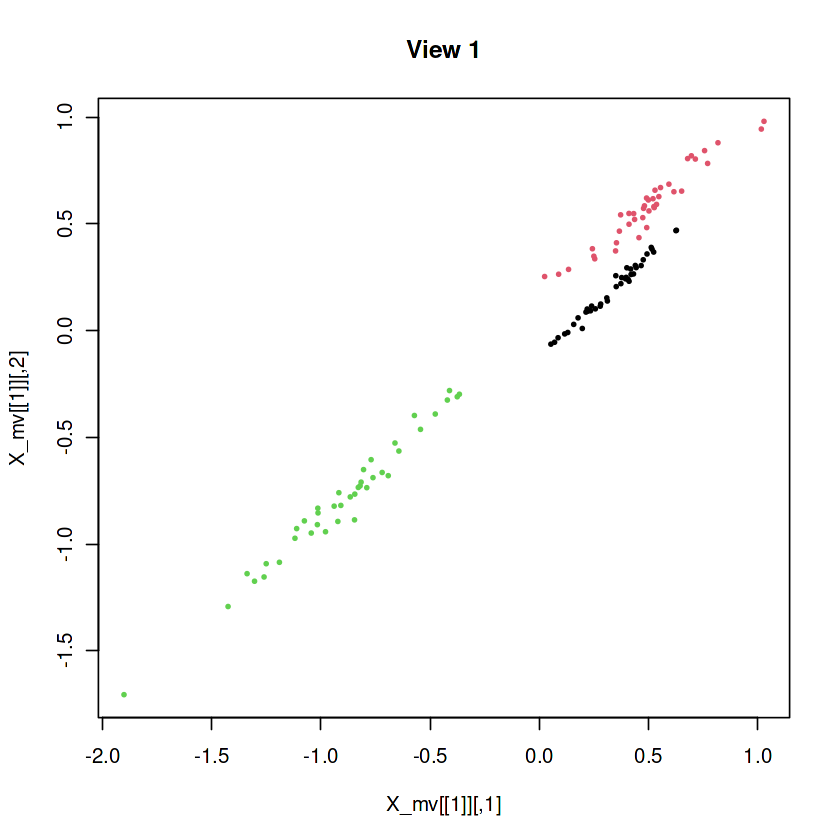

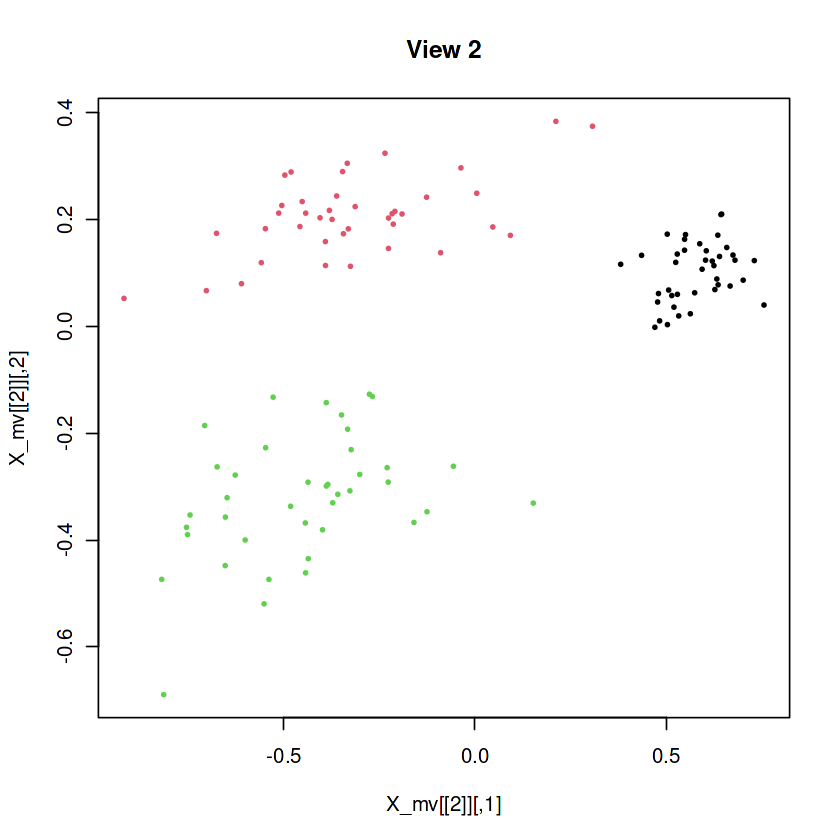

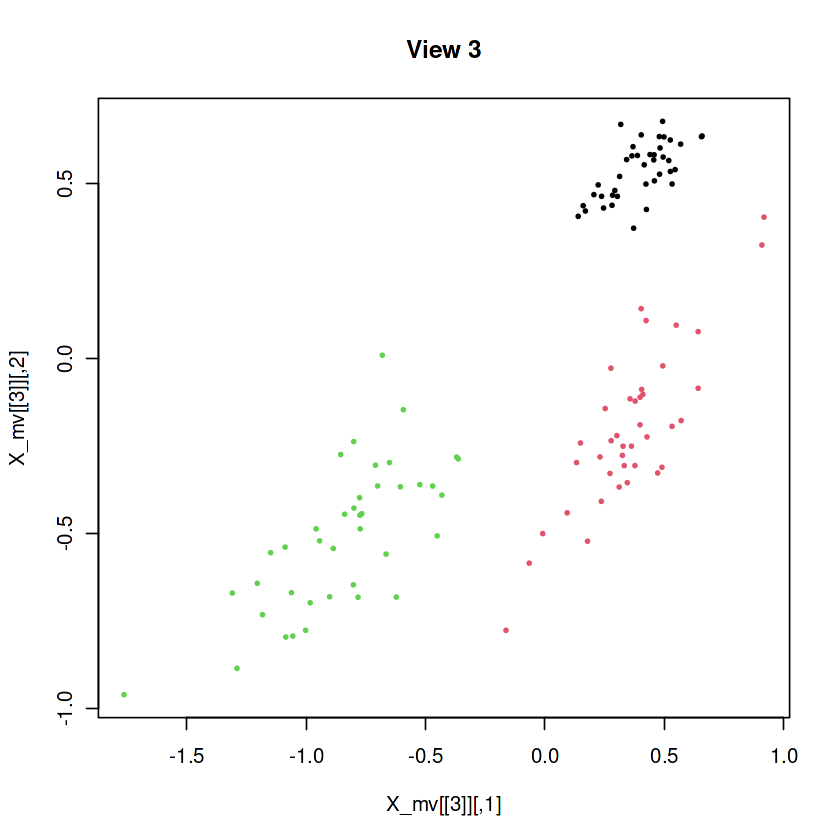

In [4]:
# 2. Generate multi-view clusters

set.seed(555)

data = multiview_clusters (n = c(40,40,40), hidden.dim = 2, observed.dim = c(2,2,2),
                           sd.max = .1, sd.noise = 0, hidden.r.range = c(.5,1))

X_mv = data[["observation"]]            # observed data
X_hidden = data[["hidden"]]             # hidden data
class_mv = data[["class"]]                 # labels

# plot(X_hidden, pch = 20, col = class, cex = .5)
plot(X_mv[[1]], pch = 20, col = class, cex = .5, main = "View 1")
plot(X_mv[[2]], pch = 20, col = class, cex = .5, main = "View 2")
plot(X_mv[[3]], pch = 20, col = class, cex = .5, main = "View 3")

## 3. Data perturbation consensus clustering (DPCC)
Here we implement DPCC (CC) based on *Monti et al. (2003)* and *Senbabaoglu at al. (2014)*.
We further calculate *stability scores* to determine the number of clusters.

### Step1. Generation mechanism
We use *hierarchical clustering* for 50 times with ```k=3```.

In [5]:
# Step 1. Generation mechanism

base_clusters = generate_data_prtrb(X, cluster.method = "hclust", k = 3, resample.ratio = 0.7, rep = 50)

dim(base_clusters)

[1] 120  50

### Step2. Consensus Mechanism
**a. Consensus matrix-based method**

  |======================================================================| 100%


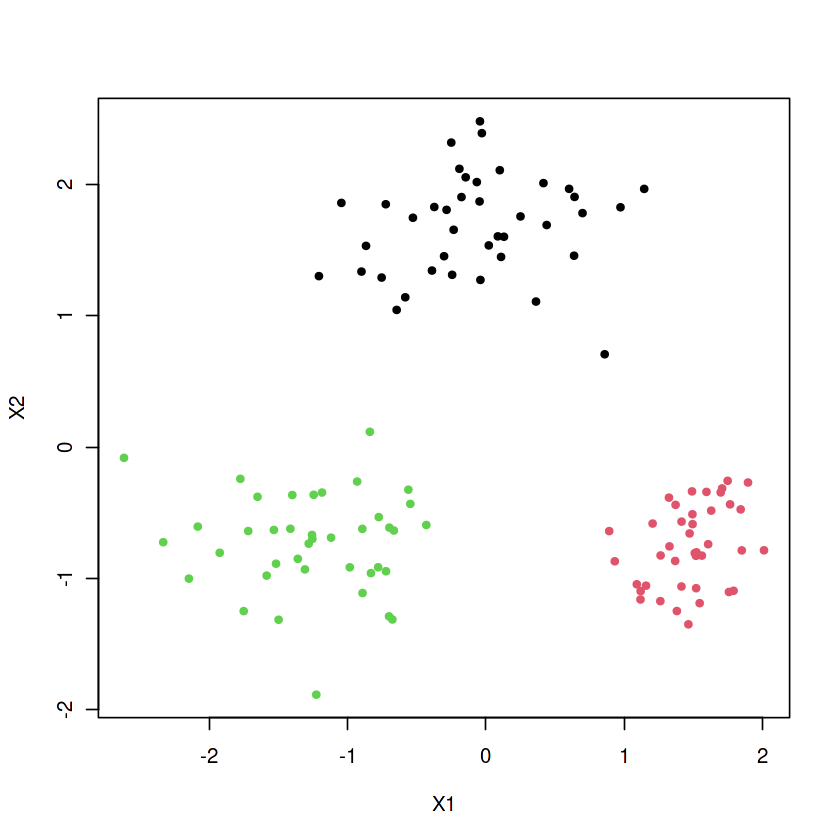

In [6]:
# Step 2.a. Consensus mechanism using consensus matrix-based method

CM = coCluster_matrix(base_clusters)
final_clusters = hir_clust_from_adj_mat(CM, k = 3)

plot(X, pch = 20, col = final_clusters, cex = 1)

**b. Majority voting method**

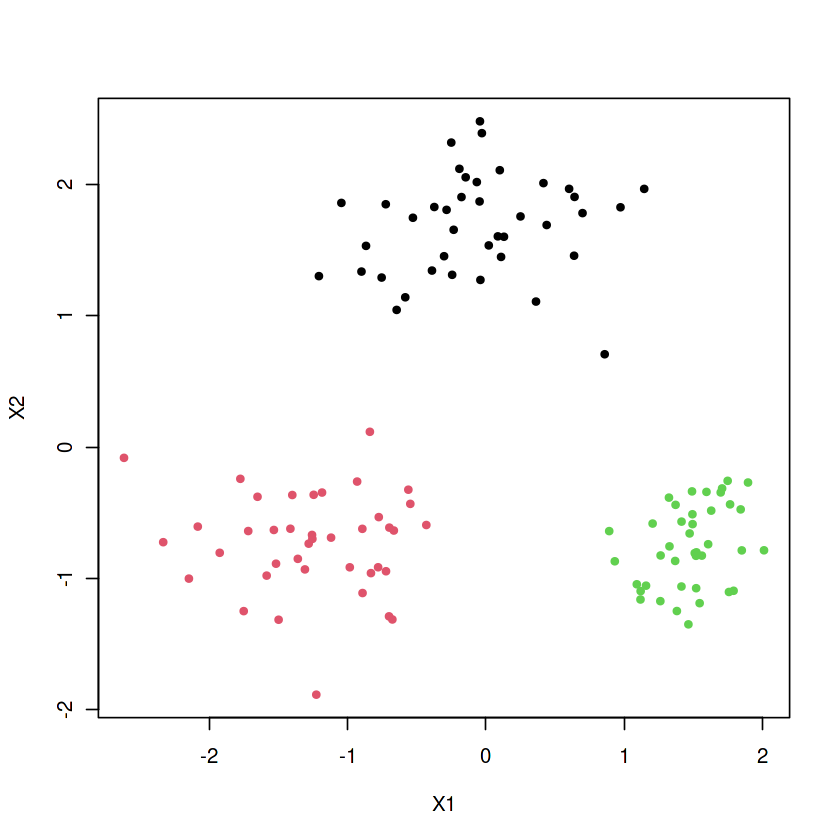

In [7]:
# Step 2.b. Consensus mechanism using majority voting

final_clusters = majority_voting(base_clusters)

plot(X, pch = 20, col = final_clusters, cex = 1)

### End-to-end DPCC estimating the number of clusters

A challange in clustering is to estimate the number of clusters. DPCC provides a framework to estimagte the number of clusters based a stability score. For this, we need to calculate the consensus matrix (CM) for different number of clusters k and obtain the clustering stability for each k. The number of clusters can be determined based on these stability scores (see Yousefi et al. 2024).

The whole process can be implemented with few lines of codes as in the following. 

In [8]:
# step 0. Calculate the adjacency matrix (as the algorithm requires a similarity matrix)
Adj = adj_mat(X, method = "euclidian")

# step 1. Generation mechanism and calculate consensus matrix (step 1 and step 2 for different values of k)
CM = consensus_matrix_data_prtrb(Adj, max.cluster = 5, resample.ratio = 0.7, max.itter = 50, clustering.method = "hclust")


[1] "Algorithm Starts...!"
[1] "Number of clusters: 2"
  |======================================================================| 100%
[1] "Number of clusters: 3"
  |======================================================================| 100%
[1] "Number of clusters: 4"
  |======================================================================| 100%
[1] "Number of clusters: 5"
  |======================================================================| 100%


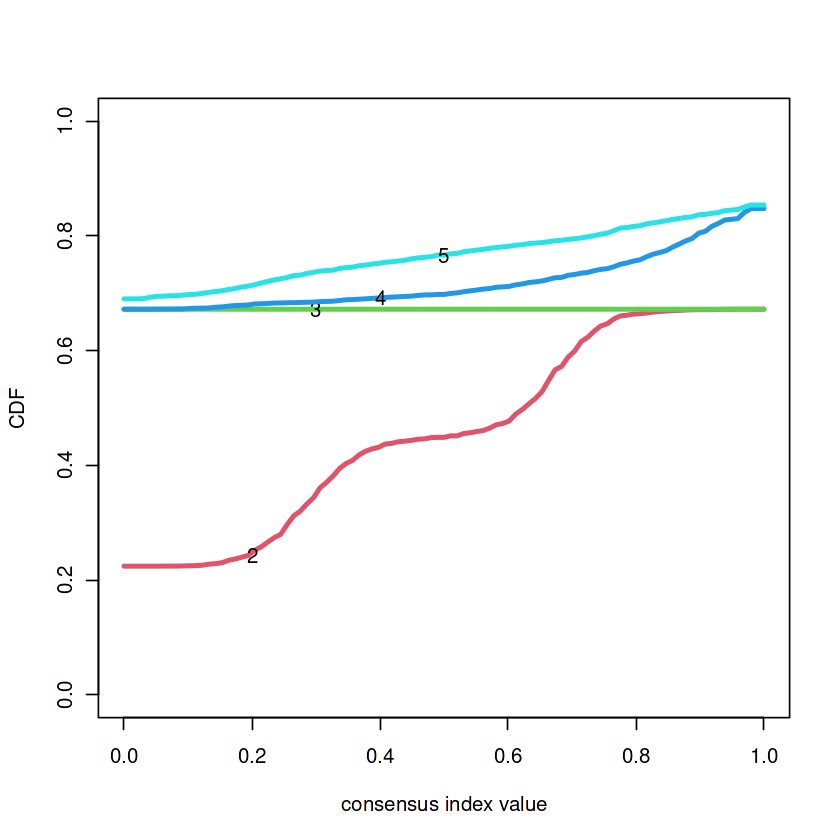

In [9]:
# step 2. Calculate stability score and determine the optimum number of clusters
Scores = cc_cluster_count(CM)


The figure above shows the empirical cumulative distribution of CMs, based on which stabilty scores has been calculated and stored in ```Scores```

In [10]:
LogitScore = Scores[["LogitScore"]]
PAC = Scores[["PAC"]]
deltaA = Scores[["deltaA"]]
CMavg = Scores[["CMavg"]]

In our previus study (Yousefi et al. 2024), we showed the superioty of *LogitScore* with respect to the other scores. We therefore obtain the optimum value of k (```Kopt```) using LogitScore.

The optimum number of clusters = 3



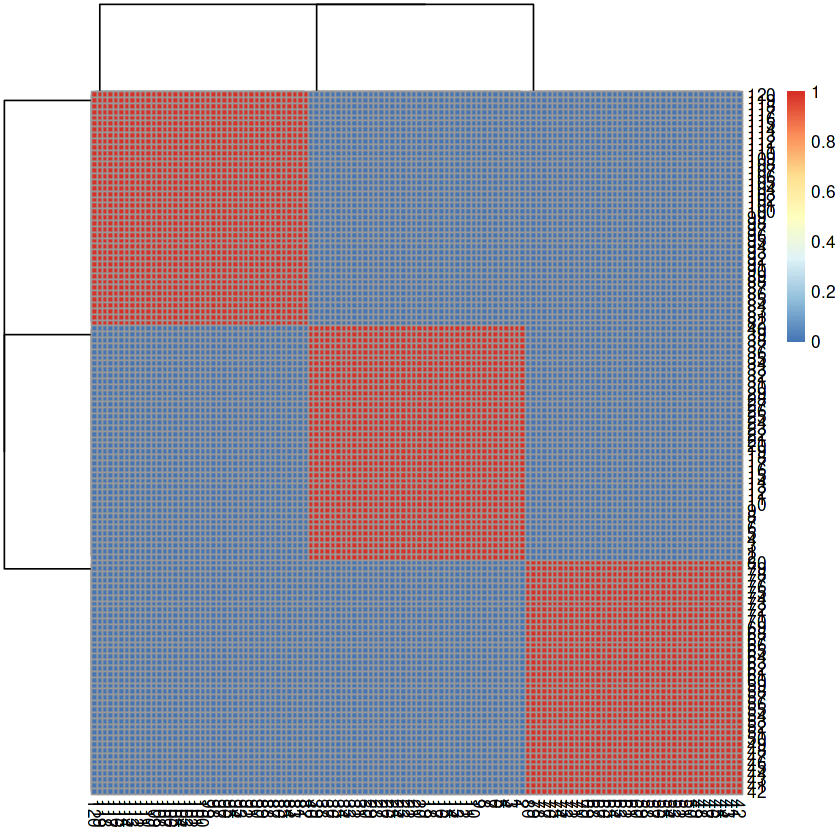

In [11]:
# Obtain the optimum k
Kopt = Scores[["Kopt_LogitScore"]]
message(paste0("The optimum number of clusters = ", Kopt))

pheatmap::pheatmap(CM[[Kopt]])


Finally, we obtain the consensus clusters using ```CM[[Kopt]]``` as a similary measure.

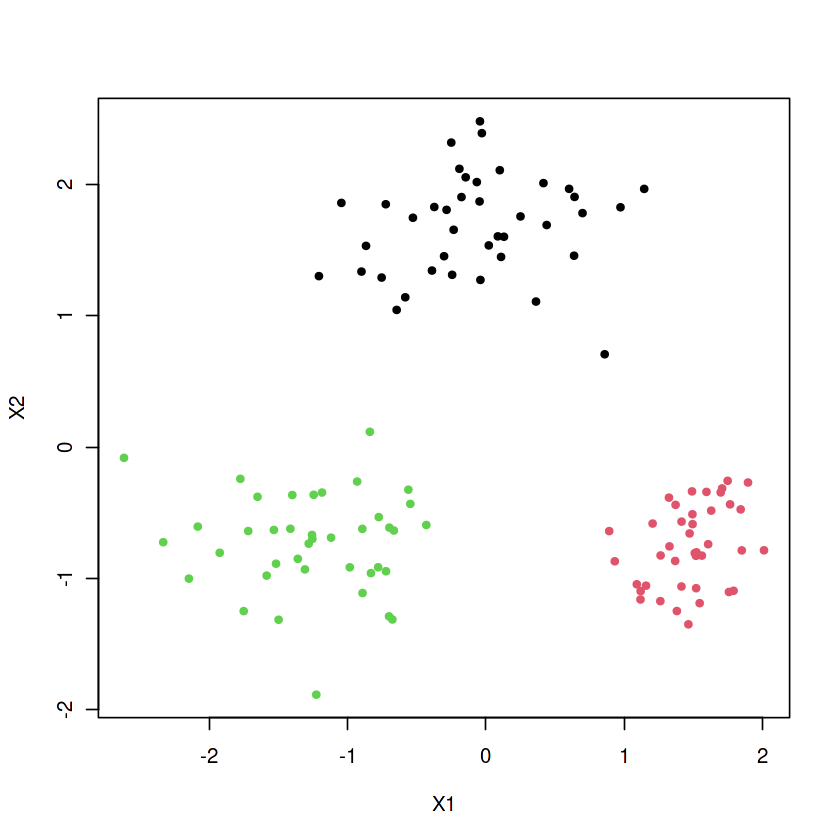

In [12]:
# Clustering consensus matrix

clusters = hir_clust_from_adj_mat(CM[[Kopt]], k = Kopt, alpha = 1, adj.conv = FALSE)
# clusters = spect_clust_from_adj_mat(Adj, k = Kopt, max.eig = Kopt, alpha = 1, adj.conv = TRUE)
# clusters = pam_clust_from_adj_mat(CM[[Kopt]], k = 2, alpha = 1, adj.conv = TRUE)

plot(X, pch = 20, col = clusters, cex = 1)

## 4. Method perturbation consensus clustering (MPCC)

Here we implement MDCC that involves diffeent methods or hyperparameters (e.g. k) of a same method.
Like in the case of DPCC, we use consensus matrix-based and majority voting method for consensus mechanism.

### Step1. Generation mechanism

The generation mechanism in MPCC can be implemented by

1. different hyperparameters of the same clustering method
2. different clustering methods
3. a combinantion of the above options.


The code below shows an example of generating different base clusterings using *k-medoids* clustering for 100 times each with a randomly selected k between 2 and 10 (as the scenario 1).

In [13]:
# Step 1.a. Generation mechanism

base_clusters_1 = generate_method_prtrb(X, cluster.method = "pam", range.k = c(2, 5), 
                                        sample.k.method = "random",rep = 100)

dim(base_clusters_1)

[1] 120 100

The code below shows an example of generating different base clusterings using *hierarchical clustering*, *spectral clustering*, and *k-medoids clustering* (as the scenario 2).

In [14]:
# Step 1.b. Generation mechanism
Adj = adj_mat(X, method = "euclidian")

base_clusters_a = hir_clust_from_adj_mat(Adj, k=3)
base_clusters_b = spect_clust_from_adj_mat(Adj, k=3)
base_clusters_c = pam_clust_from_adj_mat(Adj, k=3)

base_clusters_2 = cbind(base_clusters_a, base_clusters_b, base_clusters_c)
print(head(base_clusters_2))

  base_clusters_a base_clusters_b base_clusters_c
1               1               2               1
2               1               2               1
3               1               2               1
4               1               2               1
5               1               2               1
6               1               2               1


### Step2. Consensus Mechanism
**a. Consensus matrix-based method**

  |======================================================================| 100%


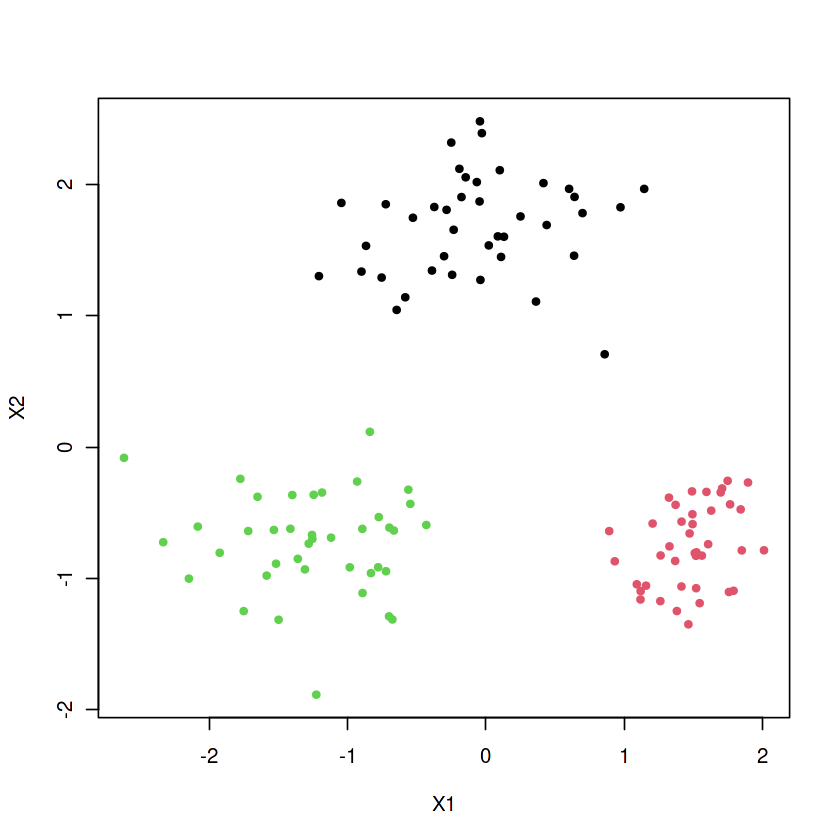

In [15]:
# Step 2.a. Consensus mechanism using consensus matrix-based method

CM = coCluster_matrix(base_clusters_1)
final_clusters = hir_clust_from_adj_mat(CM, k = 3)

plot(X, pch = 20, col = final_clusters, cex = 1)

[1] "Algorithm Starts...!"
[1] "Number of clusters: 2"
  |======================================================================| 100%
[1] "Number of clusters: 3"
  |======================================================================| 100%
[1] "Number of clusters: 4"
  |======================================================================| 100%
[1] "Number of clusters: 5"
  |======================================================================| 100%


The optimum number of clusters = 3



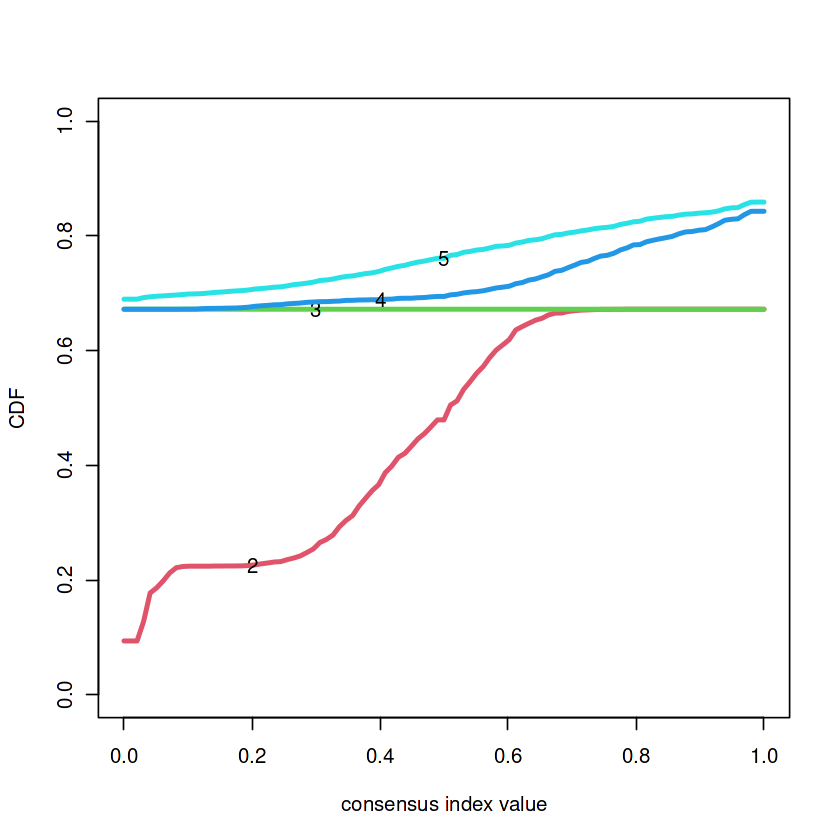

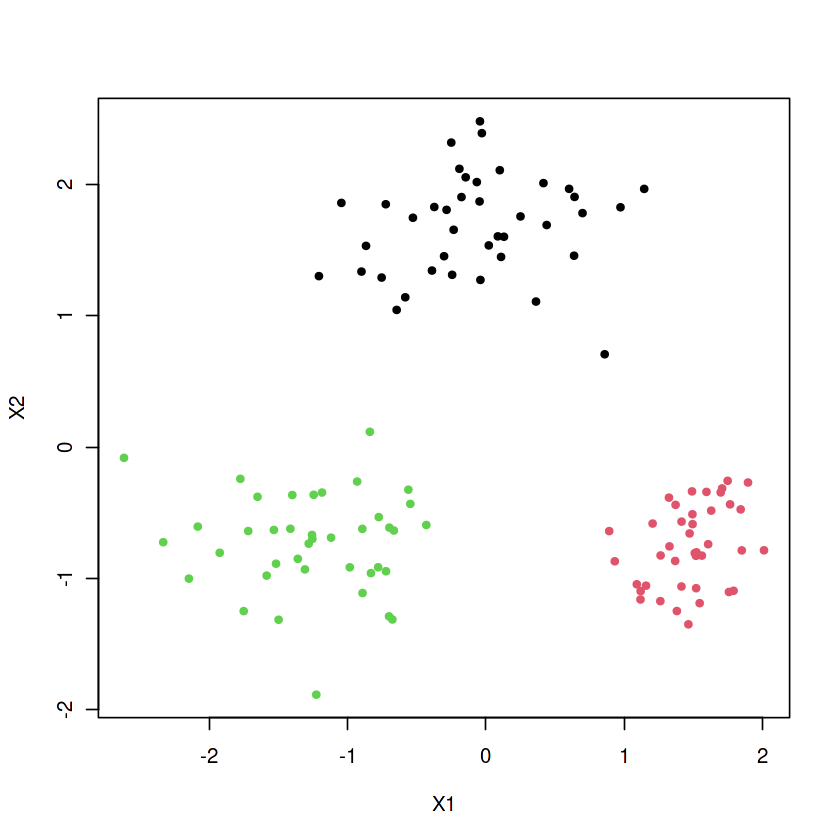

In [18]:
# (Optional) use MDCCC to obtain the number of clusters

CM_dpcc = consensus_matrix_data_prtrb(Adj, max.cluster = 5, resample.ratio = 0.7, max.itter = 50, clustering.method = "hclust")
Scores = cc_cluster_count(CM_dpcc)
Kopt = Scores[["Kopt_LogitScore"]]
message(paste0("The optimum number of clusters = ", Kopt))

clusters = hir_clust_from_adj_mat(CM_dpcc[[Kopt]], k = Kopt, alpha = 1, adj.conv = FALSE)
plot(X, pch = 20, col = clusters, cex = 1)

**b. Majority voting method**

**Note:** The ```majority_voting()``` function is assums that all clusterings have the same k; thus, it is compatible with the 2nd scenario of the generation mechanism.

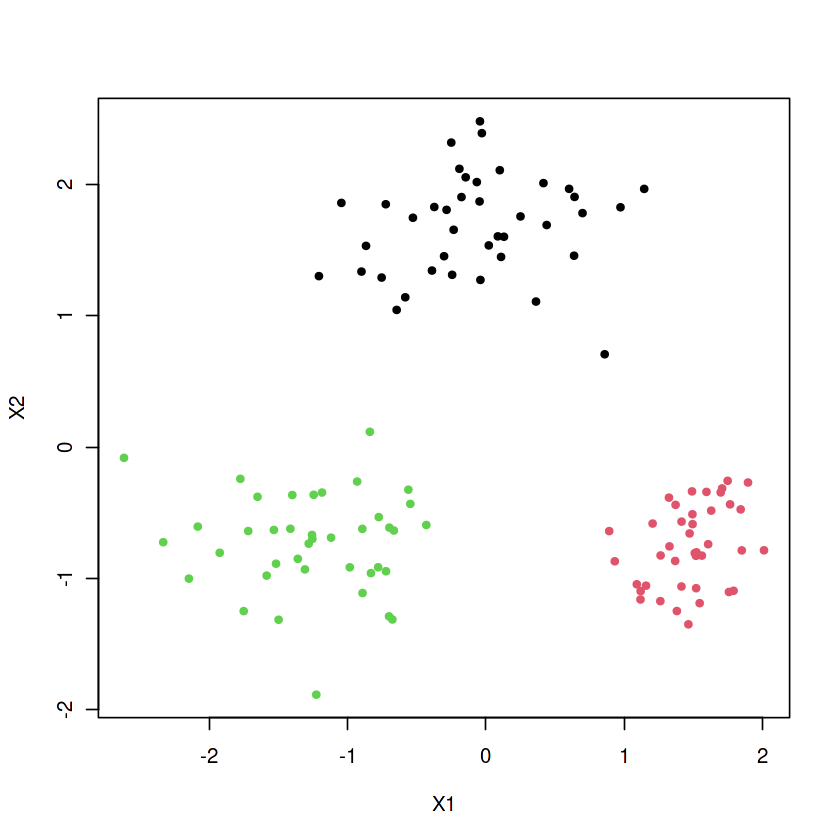

In [19]:
# Step 2.b. Consensus mechanism using majority voting

final_clusters = majority_voting(base_clusters_2)

plot(X, pch = 20, col = final_clusters, cex = 1)

## 5. Multi-Data consensus clustering (MDCC)

Here we implement MDCC that involves diffeent data sets, i.e. either *multi-cohort clustering* or *multi-view clustering*.

We consider two mwthods:
1. MDCC based on DPCC: each data view is considered as a perturbed version of the hidden state.
2. MDCC based on MPCC: perform MPCC on each view and then aggregate.

### 5.1. MDCC based on DPCC
Here, we implement a similar piplien as we applied for DPCC. Using ```consensus_matrix_multiview()```, we can apply DPCC on each view/dataset with different values of k. Then we use stability score to estimate the number of clusters.

**Note:** The input of the ```consensus_matrix_multiview()``` function is a ```list``` of adjacency matrices.

**Note:** This method may not be an approperitae choice when there are few number of view/dataset.

[1] "Algorithm Starts...!"
[1] "Number of clusters: 2"
  |======================================================================| 100%
[1] "Number of clusters: 3"
  |======================================================================| 100%
[1] "Number of clusters: 4"
  |======================================================================| 100%
[1] "Number of clusters: 5"
  |======================================================================| 100%


The optimum number of clusters = 3



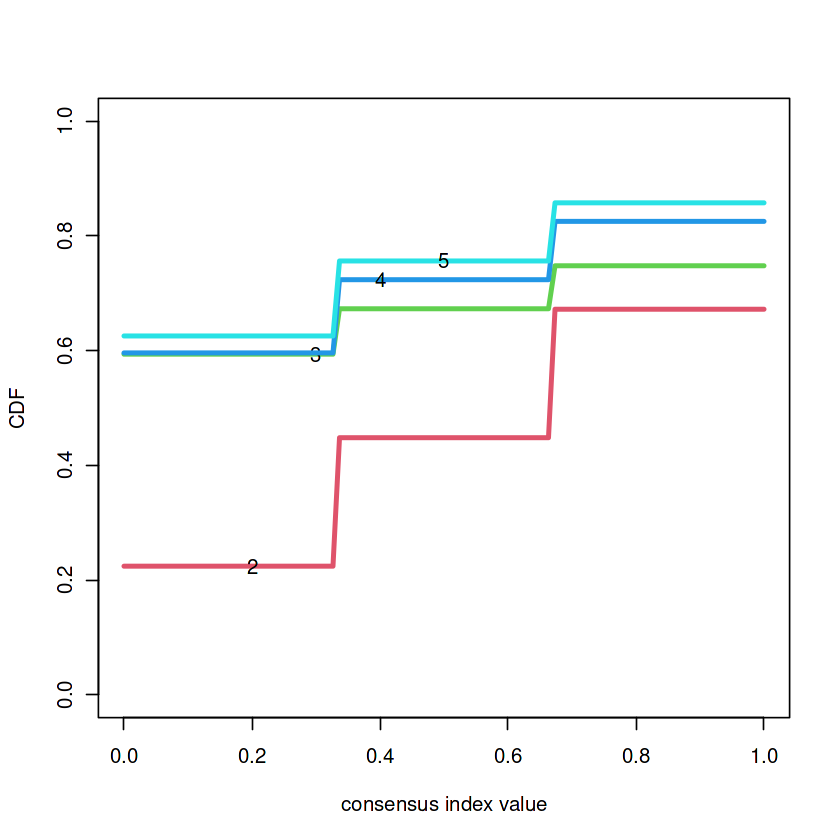

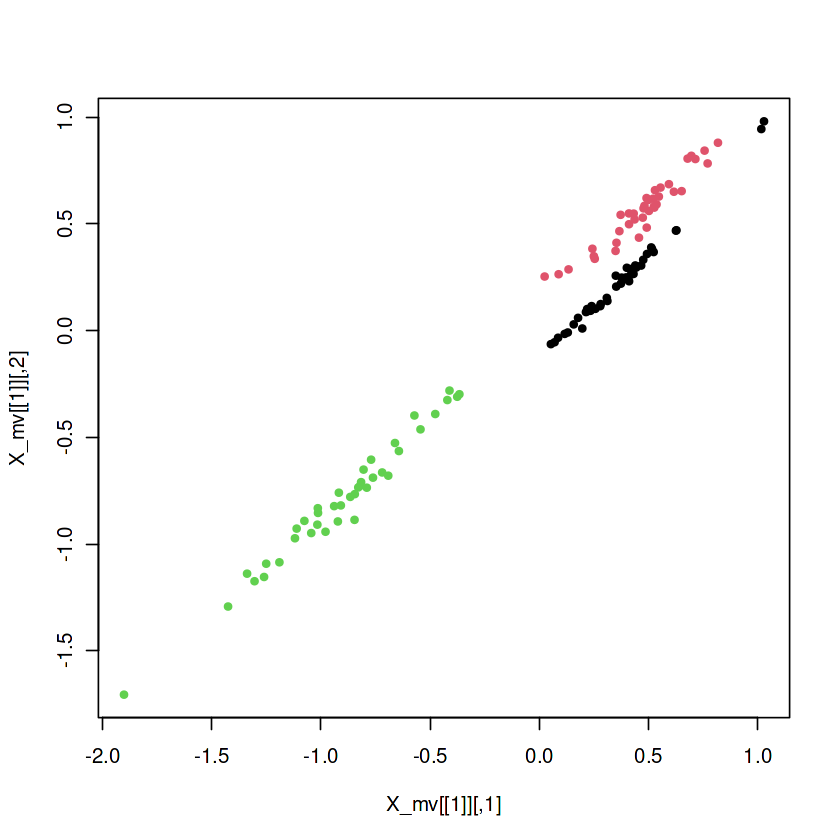

In [20]:
Adj_list = list()
for (i in 1:length(X_mv)){
  Adj_list[[i]] = adj_mat(X_mv[[i]], method = "euclidian")
}

CM = consensus_matrix_multiview(Adj_list, max.cluster = 5, clustering.method = "hclust")

Scores = cc_cluster_count(CM)
K_opt = Scores[["Kopt_LogitScore"]]
message(paste0("The optimum number of clusters = ", Kopt))

clusters = hir_clust_from_adj_mat(CM[[Kopt]], k = Kopt, alpha = 1, adj.conv = FALSE)
plot(X_mv[[1]], pch = 20, col = clusters, cex = 1)

### 5.2. MDCC based on MPCC
Here, we use the ```generate_multiview()``` function to apply MDCC on each view/dataset, and then obtain the consenus clusters. As before, both consensus matrix-based and majority voting method can be use for consensus mechanism.

  |======================================================================| 100%


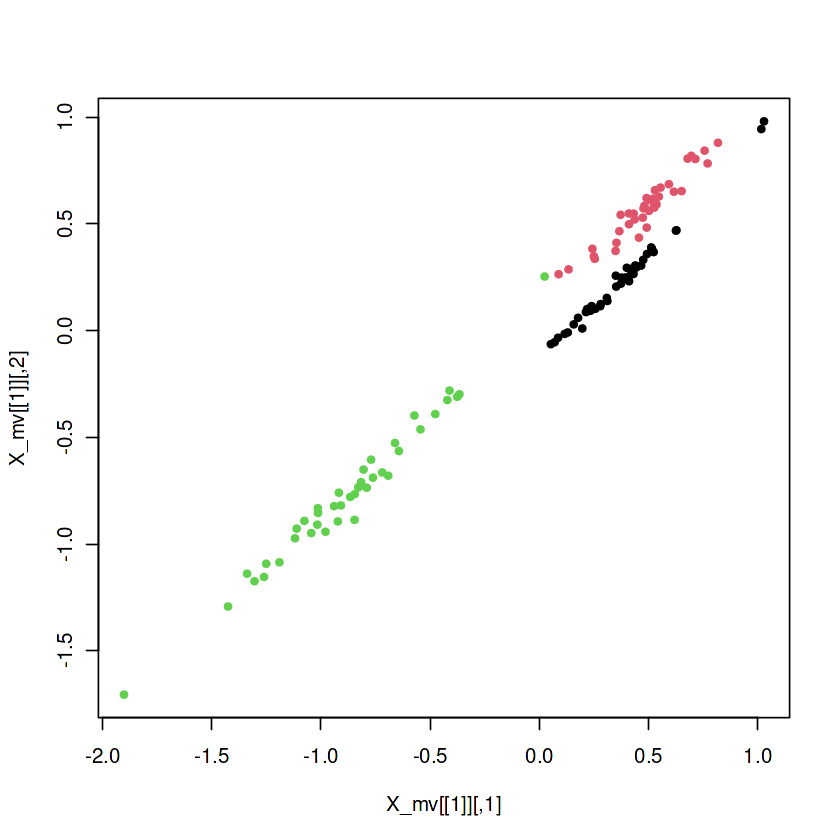

In [21]:
base_clusters = generate_multiview(X_mv, cluster.method = "pam", range.k = c(2, 5), 
                                      sample.k.method = "random",rep = 100)

Adj = coCluster_matrix(base_clusters)
final_clusters = pam_clust_from_adj_mat(Adj, k = 3)
plot(X_mv[[1]], pch = 20, col = final_clusters, cex = 1)